In [3]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv(r"C:\Users\annab\OneDrive\Documentos\GitHub\Colabs\bases\data_prema.csv")

# Processamento

In [4]:
df = df.drop(['RACACOR','CODOCUPMAE','ESCMAE', 'ESCMAE2010',
              'SERIESCMAE','SEMAGESTAC','IDADEPAI', 'DTNASCMAE',
              'STDNEPIDEM', 'STDNNOVA','TPAPRESENT', 'STTRABPART',
              'TPMETESTIM','IDANOMAL', 'CODANOMAL', 'CODESTAB',
              'CODMUNNASC', 'LOCNASC', 'CODMUNRES', 'DTNASC',
              'HORANASC','PARTO', 'PESO', 'APGAR1', 'APGAR5',
              'DTCADASTRO', 'NUMEROLOTE', 'VERSAOSIST', 'DTRECEBIM',
              'DIFDATA', 'DTRECORIGA', 'NATURALMAE', 'CODMUNNATU',
              'CODUFNATU', 'DTULTMENST', 'CONSPRENAT', 'STCESPARTO',
              'TPNASCASSI', 'TPFUNCRESP', 'TPDOCRESP', 'DTDECLARAC',
              'CODPAISRES', 'TPROBSON', 'KOTELCHUCK', 'CONTADOR', 'ORIGEM'], axis=1)

In [5]:
df = df [(df['QTDFILVIVO'] < 12)]
df = df [(df['QTDFILMORT'] < 8)]
df = df[(df['IDADEMAE'] < 54)]

In [6]:
faixas_etarias = [0, 19, 24, 29, 34, 54]
rotulos_etarias = ['0-19', '20-24', '25-29', '30-34', '35-54']
df['FAIXA_ETARIA'] = pd.cut(df['IDADEMAE'], bins=faixas_etarias, labels=rotulos_etarias, right=False)
mapeamento_faixa_etaria = {'0-19': 0, '20-24': 1, '25-29': 2, '30-34': 3, '35-54': 4}
df['FAIXA_ETARIA_INT'] = df['FAIXA_ETARIA'].map(mapeamento_faixa_etaria)

df = df.drop(['FAIXA_ETARIA', 'IDADEMAE'], axis= 1)
df = df.dropna()

In [7]:
df_prema = df[df['GESTACAO'] <= 4].copy()
df_normal = df[df['GESTACAO'] > 4].copy()

df_prema['CLASSE'] = 1
df_normal['CLASSE'] = 0

In [8]:
df = df.drop(columns = ['GESTACAO'])

In [9]:
n_samples = len(df_prema)
df_normal_new = df_normal.sample(n=n_samples, random_state=42)

print("Tamanho de df_prema:", len(df_prema))
print("Tamanho de df_normal (após undersampling):", len(df_normal_new))

Tamanho de df_prema: 54706
Tamanho de df_normal (após undersampling): 54706


In [10]:
df_unificado = pd.concat([df_prema, df_normal_new], ignore_index=True)
df_unificado = df_unificado.drop(columns = ['GESTACAO'])

# Modelo

Melhores parâmetros encontrados: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 15}
              precision    recall  f1-score   support

           0       0.61      0.78      0.68     16247
           1       0.70      0.51      0.59     16577

    accuracy                           0.64     32824
   macro avg       0.65      0.64      0.64     32824
weighted avg       0.66      0.64      0.64     32824



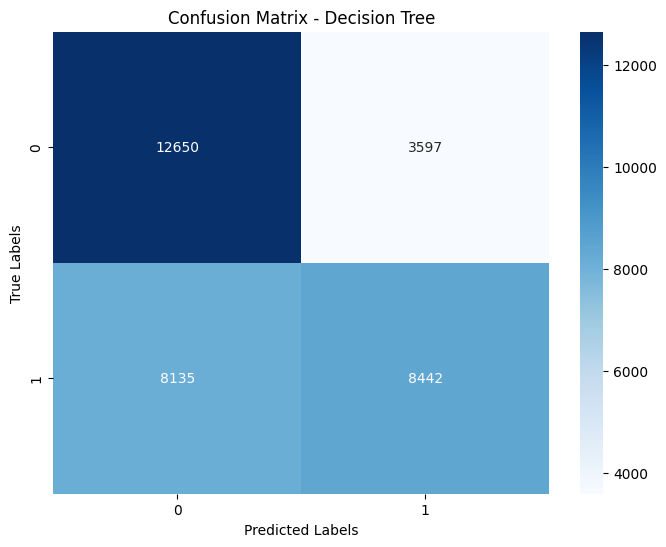

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

X = df_unificado.drop('CLASSE', axis=1)
y = df_unificado['CLASSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 10]
}

dt_model = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_dt.fit(X_train, y_train)
best_params_dt = grid_search_dt.best_params_
print("Melhores parâmetros encontrados:", best_params_dt)

best_dt_model = DecisionTreeClassifier(random_state=42, **best_params_dt)
best_dt_model.fit(X_train, y_train)

y_pred_dt = best_dt_model.predict(X_test)
print(classification_report(y_test, y_pred_dt))

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap="Blues",
            xticklabels=best_dt_model.classes_,
            yticklabels=best_dt_model.classes_,
            cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

# Acurácia

Melhor Threshold Calculado: 0.4865
Melhor Acurácia Correspondente: 0.6428


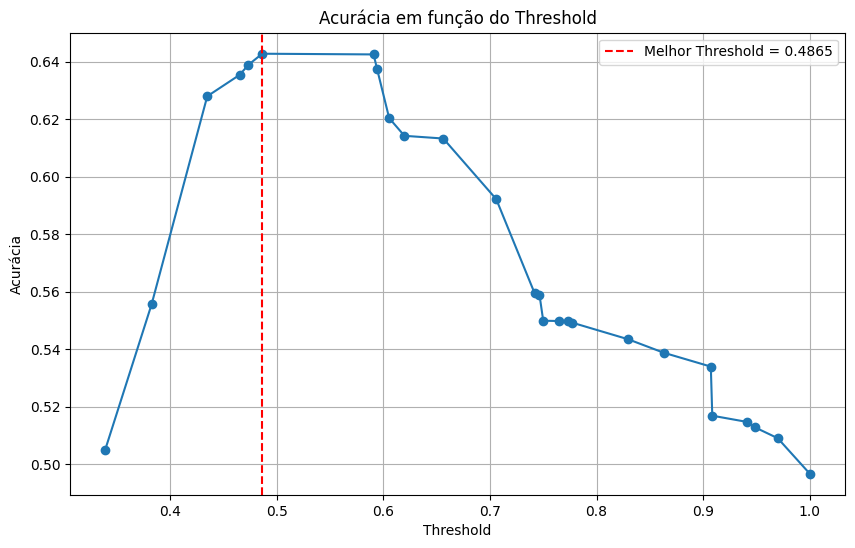

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score

y_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]
unique_thresholds = np.sort(np.unique(y_prob_dt))

accuracies = []

for threshold in unique_thresholds:
    y_pred_threshold = (y_prob_dt >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred_threshold)
    accuracies.append(acc)

best_threshold_index = np.argmax(accuracies)
best_threshold = unique_thresholds[best_threshold_index]
best_accuracy = accuracies[best_threshold_index]

print(f"Melhor Threshold Calculado: {best_threshold:.4f}")
print(f"Melhor Acurácia Correspondente: {best_accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(unique_thresholds, accuracies, marker='o')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f"Melhor Threshold = {best_threshold:.4f}")
plt.xlabel('Threshold')
plt.ylabel('Acurácia')
plt.title('Acurácia em função do Threshold')
plt.legend()
plt.grid()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Threshold Utilizado: 0.4800
Acurácia: 0.6428
Precisão (PPV): 0.7013
Recall (Sensibilidade): 0.5100
F1-Score: 0.5905
Especificidade: 0.7784
PPV: 0.7013
NPV: 0.6089
FPR (Taxa de Falsos Positivos): 0.2216
Classificados Corretamente: 21100 de 32824


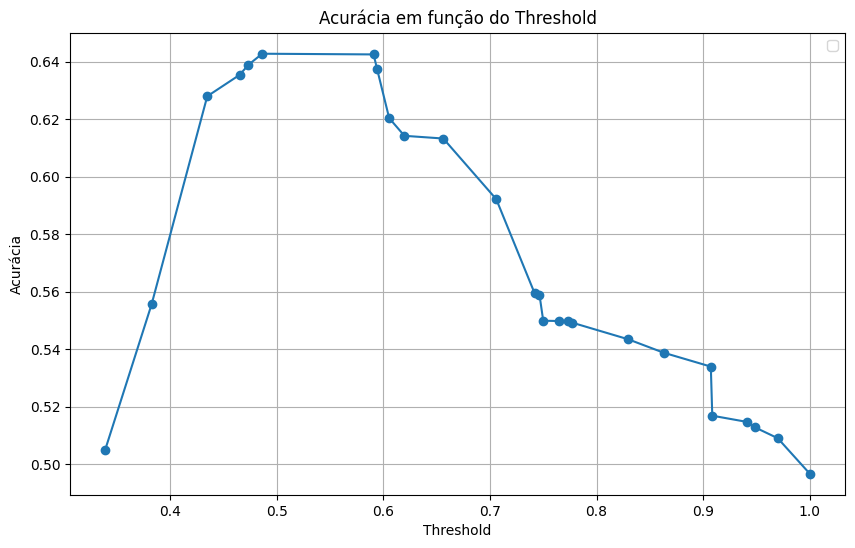

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]

threshold = 0.48
y_pred_threshold = (y_prob_dt >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()

accuracy = accuracy_score(y_test, y_pred_threshold)
precision = precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = precision
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
correctly_classified = accuracy * len(y_test)

print(f"Threshold Utilizado: {threshold:.4f}")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão (PPV): {precision:.4f}")
print(f"Recall (Sensibilidade): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"PPV: {ppv:.4f}")
print(f"NPV: {npv:.4f}")
print(f"FPR (Taxa de Falsos Positivos): {fpr:.4f}")
print(f"Classificados Corretamente: {correctly_classified:.0f} de {len(y_test)}")

plt.figure(figsize=(10, 6))
plt.plot(unique_thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Acurácia')
plt.title('Acurácia em função do Threshold')
plt.legend()
plt.grid()
plt.show()

# Sensibilidade

Melhor Threshold para Recall: 0.3393
Melhor Valor de Recall: 1.0000


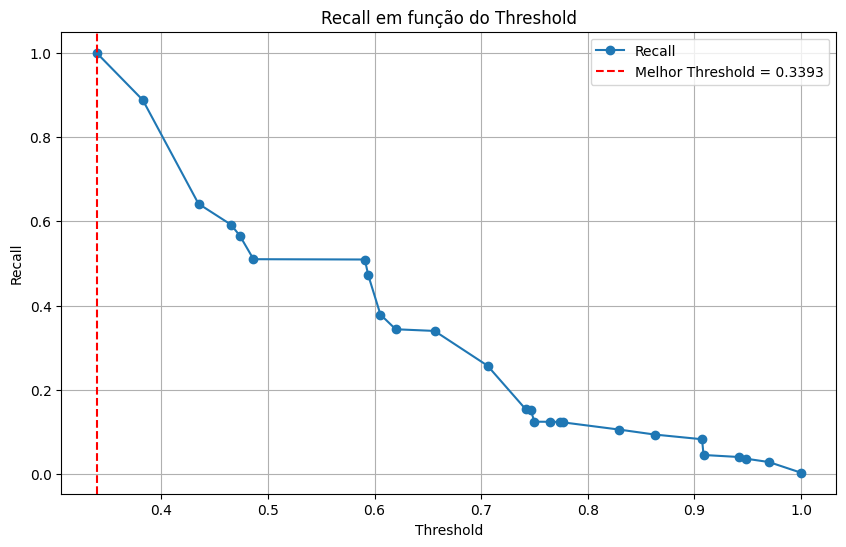

In [14]:
import numpy as np
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

y_prob_dt_recall = best_dt_model.predict_proba(X_test)[:, 1]
thresholds_recall = np.sort(np.unique(y_prob_dt_recall))

recall_values = []

for threshold in thresholds_recall:
    y_pred_dt = (y_prob_dt_recall >= threshold).astype(int)
    recall = recall_score(y_test, y_pred_dt)
    recall_values.append(recall)

best_recall_index = np.argmax(recall_values)
best_recall_threshold = thresholds_recall[best_recall_index]
best_recall_value = recall_values[best_recall_index]

print(f"Melhor Threshold para Recall: {best_recall_threshold:.4f}")
print(f"Melhor Valor de Recall: {best_recall_value:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds_recall, recall_values, marker='o', label='Recall')
plt.axvline(x=best_recall_threshold, color='red', linestyle='--', label=f"Melhor Threshold = {best_recall_threshold:.4f}")
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall em função do Threshold')
plt.legend()
plt.grid()
plt.show()

Threshold Utilizado: 0.3300
Acurácia: 0.5050
Precisão (PPV): 0.5050
Recall (Sensibilidade): 1.0000
F1-Score: 0.6711
Especificidade: 0.0000
PPV: 0.5050
NPV: 0.0000
FPR (Taxa de Falsos Positivos): 1.0000
Classificados Corretamente: 16577 de 32824


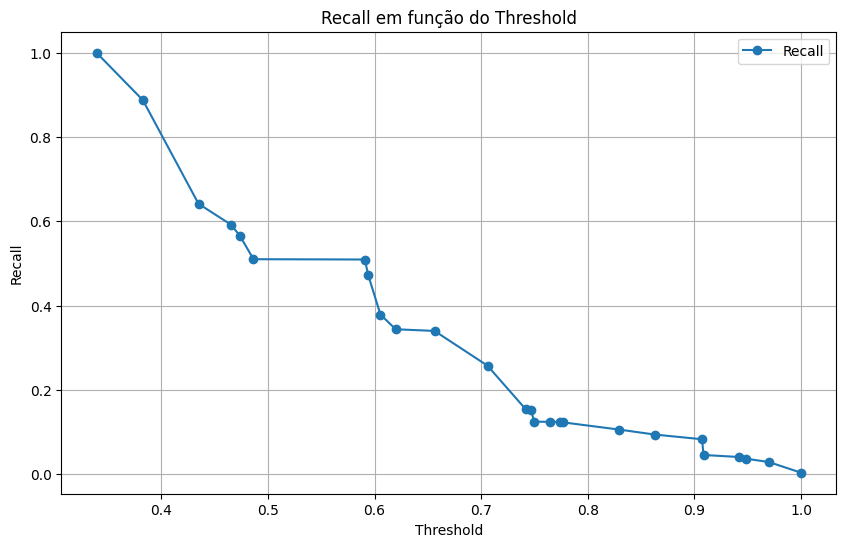

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

y_prob_dt_recall = best_dt_model.predict_proba(X_test)[:, 1]

threshold = 0.33
y_pred_threshold = (y_prob_dt_recall >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()

accuracy = accuracy_score(y_test, y_pred_threshold)
precision = precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = precision
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
correctly_classified = accuracy * len(y_test)

print(f"Threshold Utilizado: {threshold:.4f}")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão (PPV): {precision:.4f}")
print(f"Recall (Sensibilidade): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"PPV: {ppv:.4f}")
print(f"NPV: {npv:.4f}")
print(f"FPR (Taxa de Falsos Positivos): {fpr:.4f}")
print(f"Classificados Corretamente: {correctly_classified:.0f} de {len(y_test)}")

thresholds_recall = np.sort(np.unique(y_prob_dt_recall))
recall_values = []

for t in thresholds_recall:
    y_pred_dt = (y_prob_dt_recall >= t).astype(int)
    recall = recall_score(y_test, y_pred_dt)
    recall_values.append(recall)

plt.figure(figsize=(10, 6))
plt.plot(thresholds_recall, recall_values, marker='o', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall em função do Threshold')
plt.legend()
plt.grid()
plt.show()

# F1-Score

Melhor Threshold Calculado: 0.3393
Melhor F1-Score Correspondente: 0.6711


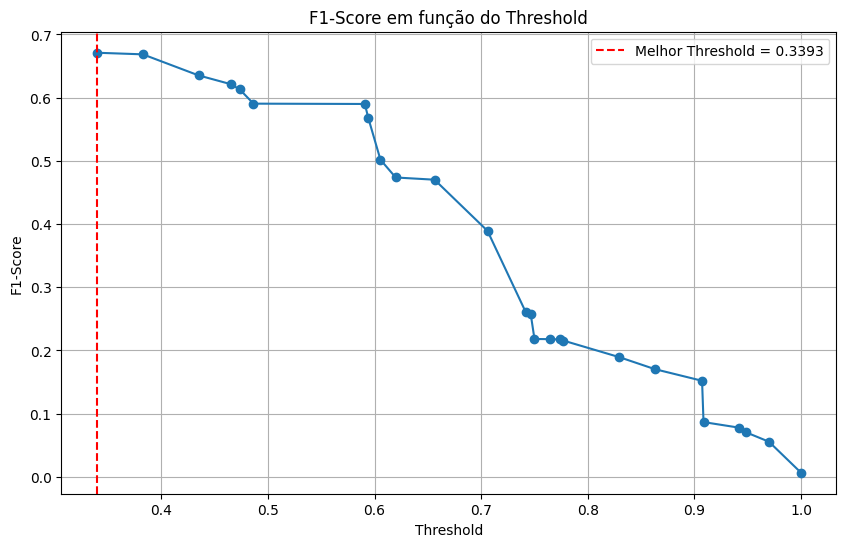

In [16]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

y_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]
unique_thresholds = np.sort(np.unique(y_prob_dt))

f1_scores = []

for threshold in unique_thresholds:
    y_pred_threshold = (y_prob_dt >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

best_threshold_index = np.argmax(f1_scores)
best_threshold = unique_thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f"Melhor Threshold Calculado: {best_threshold:.4f}")
print(f"Melhor F1-Score Correspondente: {best_f1_score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(unique_thresholds, f1_scores, marker='o')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f"Melhor Threshold = {best_threshold:.4f}")
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score em função do Threshold')
plt.legend()
plt.grid()
plt.show()


Threshold Utilizado: 0.3300
Acurácia: 0.5050
Precisão (PPV): 0.5050
Recall (Sensibilidade): 1.0000
F1-Score: 0.6711
Especificidade: 0.0000
PPV: 0.5050
NPV: 0.0000
FPR (Taxa de Falsos Positivos): 1.0000
Classificados Corretamente: 16577 de 32824


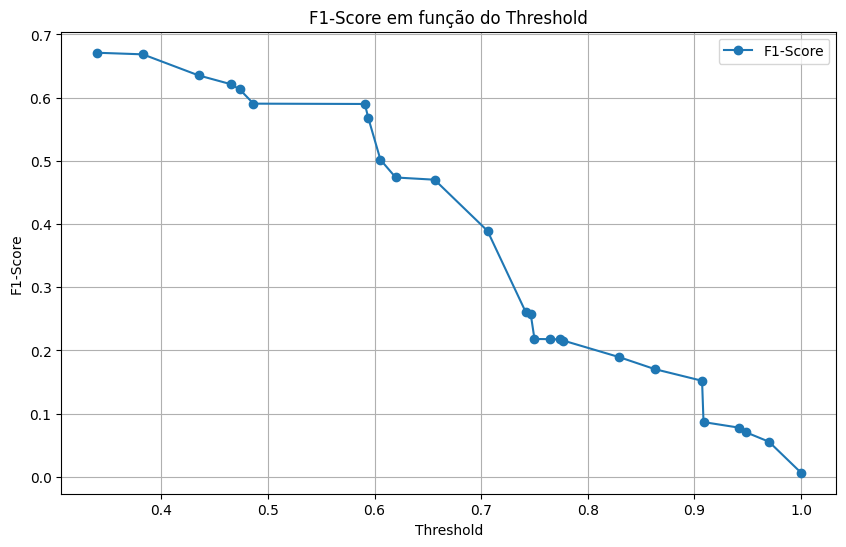

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

y_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]

threshold = 0.33
y_pred_threshold = (y_prob_dt >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()

accuracy = accuracy_score(y_test, y_pred_threshold)
precision = precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = precision
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
correctly_classified = accuracy * len(y_test)

print(f"Threshold Utilizado: {threshold:.4f}")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão (PPV): {precision:.4f}")
print(f"Recall (Sensibilidade): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"PPV: {ppv:.4f}")
print(f"NPV: {npv:.4f}")
print(f"FPR (Taxa de Falsos Positivos): {fpr:.4f}")
print(f"Classificados Corretamente: {correctly_classified:.0f} de {len(y_test)}")

thresholds_f1 = np.sort(np.unique(y_prob_dt))
f1_scores = []

for t in thresholds_f1:
    y_pred_dt = (y_prob_dt >= t).astype(int)
    f1 = f1_score(y_test, y_pred_dt)
    f1_scores.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(thresholds_f1, f1_scores, marker='o', label='F1-Score')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score em função do Threshold')
plt.legend()
plt.grid()
plt.show()

# Rocs

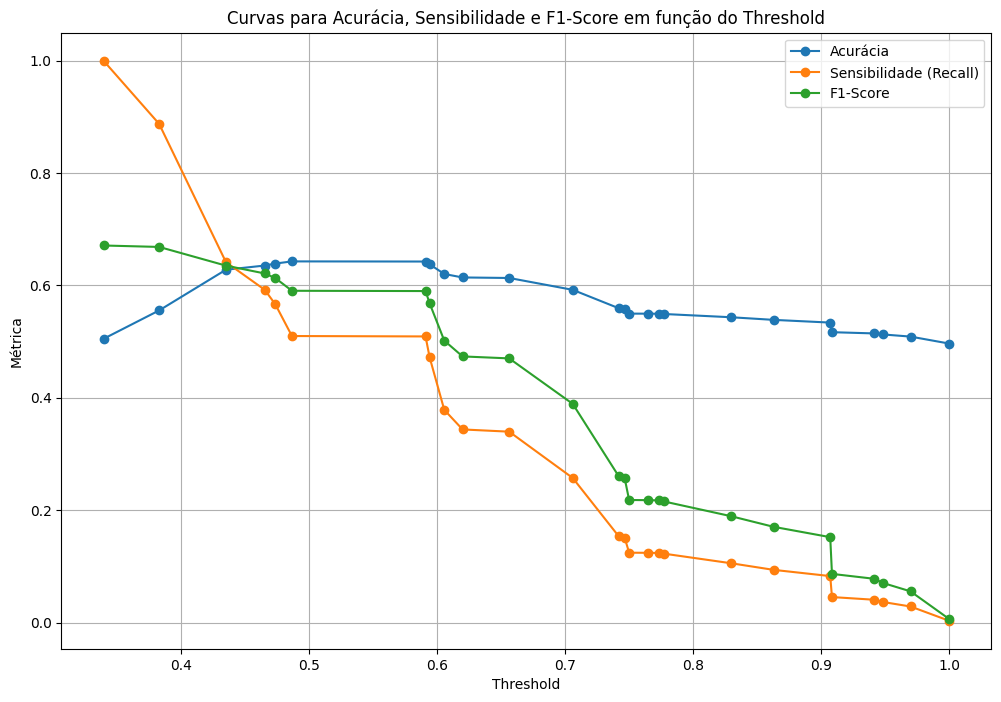

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt

y_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]
unique_thresholds = np.sort(np.unique(y_prob_dt))

accuracies = []
sensitivities = []
f1_scores = []

for threshold in unique_thresholds:
    y_pred_threshold = (y_prob_dt >= threshold).astype(int)
    accuracies.append(accuracy_score(y_test, y_pred_threshold))
    sensitivities.append(recall_score(y_test, y_pred_threshold))
    f1_scores.append(f1_score(y_test, y_pred_threshold))

plt.figure(figsize=(12, 8))

plt.plot(unique_thresholds, accuracies, label='Acurácia', marker='o')
plt.plot(unique_thresholds, sensitivities, label='Sensibilidade (Recall)', marker='o')
plt.plot(unique_thresholds, f1_scores, label='F1-Score', marker='o')

plt.xlabel('Threshold')
plt.ylabel('Métrica')
plt.title('Curvas para Acurácia, Sensibilidade e F1-Score em função do Threshold')
plt.legend()
plt.grid()
plt.show()


# Verificando...

   Threshold  Accuracy  Sensitivity (Recall)  F1-Score  Precision
0       0.48  0.642822              0.509984  0.590528   0.701286
1       0.33  0.505027              1.000000  0.671120   0.505027
2       0.33  0.505027              1.000000  0.671120   0.505027


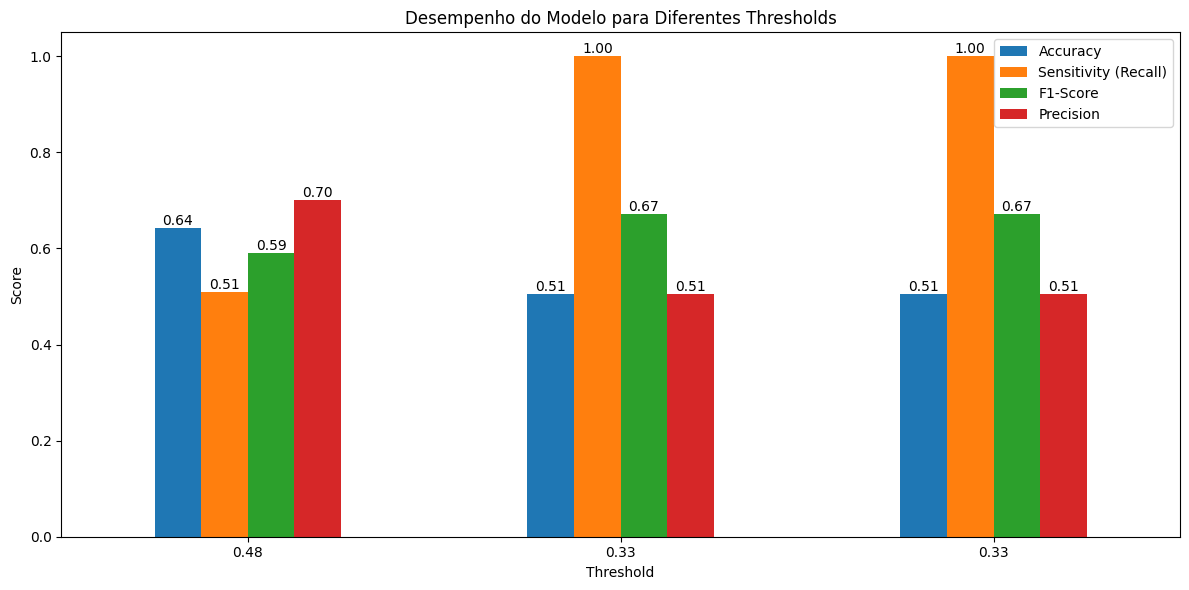

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

metrics = {
    "Threshold": [],
    "Accuracy": [],
    "Sensitivity (Recall)": [],
    "F1-Score": [],
    "Precision": []  
}

for threshold in thresholds:
    y_pred_threshold = (y_proba_dt >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold, pos_label=1)
    f1 = f1_score(y_test, y_pred_threshold)
    precision = precision_score(y_test, y_pred_threshold, pos_label=1)
    
    metrics["Threshold"].append(threshold)
    metrics["Accuracy"].append(acc)
    metrics["Sensitivity (Recall)"].append(recall)
    metrics["F1-Score"].append(f1)
    metrics["Precision"].append(precision)

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

ax = metrics_df.set_index("Threshold").plot(kind="bar", figsize=(12, 6), rot=0)
plt.title("Desempenho do Modelo para Diferentes Thresholds")
plt.ylabel("Score")
plt.xlabel("Threshold")
plt.legend(loc="best")

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom', fontsize=10 
    )

plt.tight_layout()
plt.show()
